In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_hm.utils import init_nb

init_nb()

In [2]:
os.environ['KAGGLE_HM_DATA'] = '/data/sstamenov/kaggle-data/'
data_root = Path(os.environ['KAGGLE_HM_DATA'])
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')

In [3]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.0169,2


In [4]:
df['week_no'] = df['t_dat'].dt.to_period('W')

In [5]:
sales = df.groupby(['article_id', 'week_no']).agg(cnt=('customer_id', 'count'))

In [6]:
sales = sales.reset_index()

In [7]:
sales['week_r'] = sales.groupby('article_id')['week_no'].rank()

In [8]:
sales.head()

,article_id,week_no,cnt,week_r
0,0108775015,2018-09-17/2018-09-23,115,1.0000
1,0108775015,2018-09-24/2018-09-30,547,2.0000
2,0108775015,2018-10-01/2018-10-07,315,3.0000
3,0108775015,2018-10-08/2018-10-14,360,4.0000
4,0108775015,2018-10-15/2018-10-21,259,5.0000


In [9]:
items = sales[['article_id']].drop_duplicates()

In [10]:
top = df.groupby('article_id')['customer_id'].count().sort_values(ascending=False).head(20)

In [11]:
top[:1].index

CategoricalIndex(['0706016001'], categories=['0108775015', '0108775044', '0108775051', '0110065001', '0110065002', '0110065011', '0111565001', '0111586001', ...], ordered=False, dtype='category', name='article_id')

In [12]:
from kaggle_hm.utils import plot_item

In [200]:
# sales in last 3 month? sum() > 10-100
# out of fashion things vs all-time-favourite


# hot !!! ~ not hot 

In [ ]:
# then we can categorize/analyze customers 
# buys all new ~ Fashion newsletter

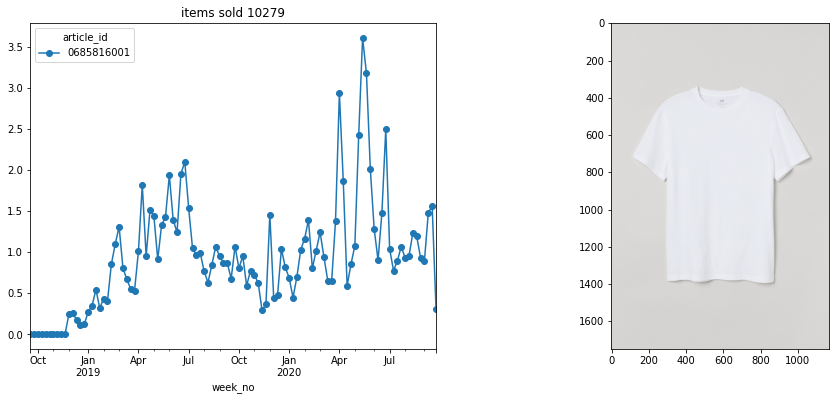

In [285]:
item_ids = items.sample(n=1)['article_id'].tolist()
# item_ids = [top.index[11]]
sample = sales[sales['article_id'].isin(item_ids)].copy()
_ = sample.pivot(index='article_id', columns='week_no', values='cnt')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
(_.apply(lambda _: _ / _.sum(), axis=1) * 100).T.plot(ax=ax[0], marker='o')
ax[0].set(title=f"items sold {sample['cnt'].sum()}")

plot_item(item_ids[0], ax=ax[1]);

In [107]:
last_weeks = sales['week_no'].unique()[-9:-3]

In [108]:
last_weeks

<PeriodArray>
['2020-07-27/2020-08-02', '2020-08-03/2020-08-09', '2020-08-10/2020-08-16',
 '2020-08-17/2020-08-23', '2020-08-24/2020-08-30', '2020-08-31/2020-09-06']
Length: 6, dtype: period[W-SUN]

In [109]:
trending = sales[sales['week_no'].isin(last_weeks)].groupby('article_id')[['cnt']].sum().reset_index()

trending[trending['cnt'] > 10]

,article_id,cnt
1,0108775044,30
6,0111565001,123
7,0111586001,215
8,0111593001,243
9,0111609001,83
...,...,...
102466,0924606001,15
102469,0926164001,33
102472,0928331001,12
102474,0929744001,42


In [50]:
# 1/N_trousers * Pr(Trousers) # and

In [14]:
train_dates = {
    'start': '2020-08-01',
    'end': '2020-09-08'
}
test_dates = {
    'start': '2020-09-09',
    'end': '2020-09-15'
}

_ = (
    (df['t_dat'] >= train_dates['start']) &
    (df['t_dat'] <= train_dates['end'])
)
train = df[_]

_ = (
    (df['t_dat'] >= test_dates['start']) &
    (df['t_dat'] <= test_dates['end'])
)
test = df[_]

In [110]:
test.shape

(255241, 6)

In [149]:
train_items_set = set(train['article_id'])

In [111]:
trending_items = set(trending[trending['cnt'] > 10]['article_id'])

In [152]:
len(train_items_set - trending_items)

16973

In [115]:
len(trending_items)

15284

In [159]:
# transactions from non-trending items
test[test['article_id'].isin(train_items_set - trending_items)].shape[0]

26973

In [153]:
# transactions from all train items
test[test['article_id'].isin(train_items_set)].shape[0]

240392

In [112]:
# transactions / items bought from just most recent items
test[test['article_id'].isin(trending_items)].shape[0]

213419

In [166]:
213419/255241

0.8361470139985347

In [168]:
0.022 / 0.006

3.6666666666666665

In [117]:
i = test[~test['article_id'].isin(trending_items)]['article_id'].value_counts()

In [64]:
from kaggle_hm.utils import visualize_items

In [118]:
_ = (
    train
    .groupby('article_id')
    .agg(
        min_dt=('t_dat', 'min'), 
        total_cnt=('customer_id', 'count')
    ).reset_index()
)

In [119]:
_[_['article_id'].isin(i.index)].sort_values('min_dt').head(25)

,article_id,min_dt,total_cnt
1,0108775044,2020-08-01,25
85070,0848864001,2020-08-01,22
85075,0851633006,2020-08-01,12
85086,0854384004,2020-08-01,13
85088,0854715001,2020-08-01,132
85091,0855827002,2020-08-01,21
85093,0859136002,2020-08-01,533
85094,0859622005,2020-08-01,4
85096,0860264001,2020-08-01,27
85102,0862496001,2020-08-01,58


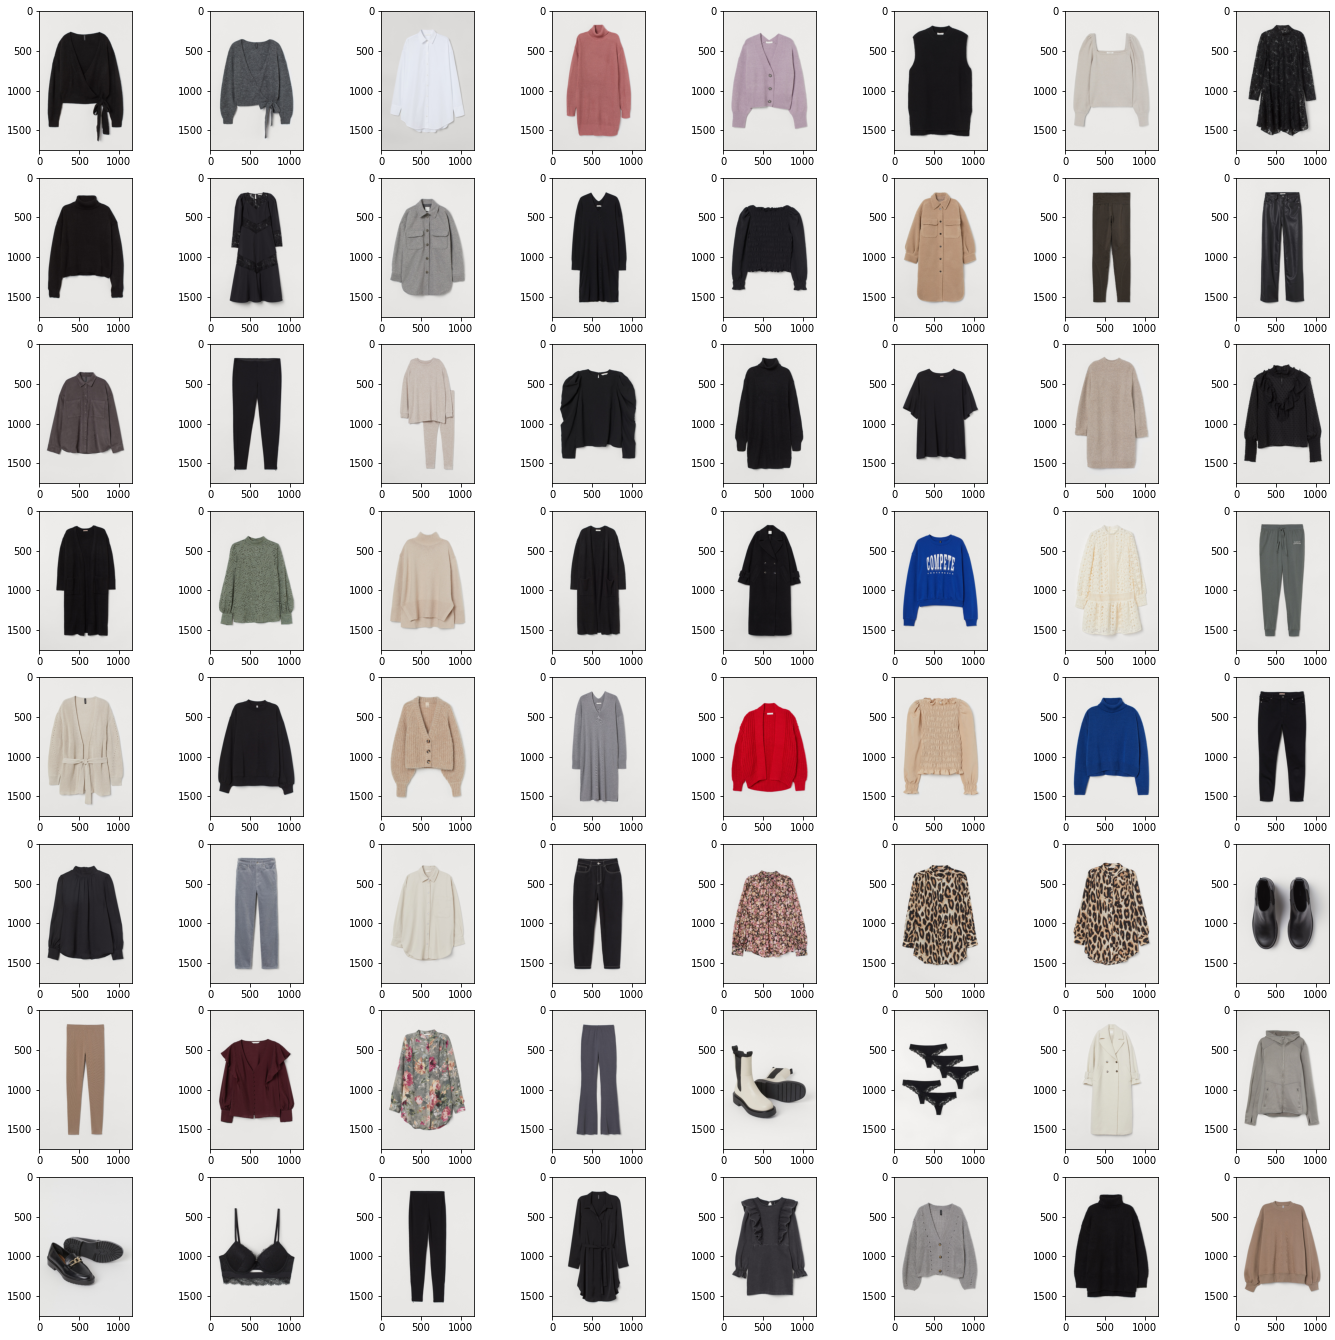

In [120]:
visualize_items(i.index)

# old items that are bought

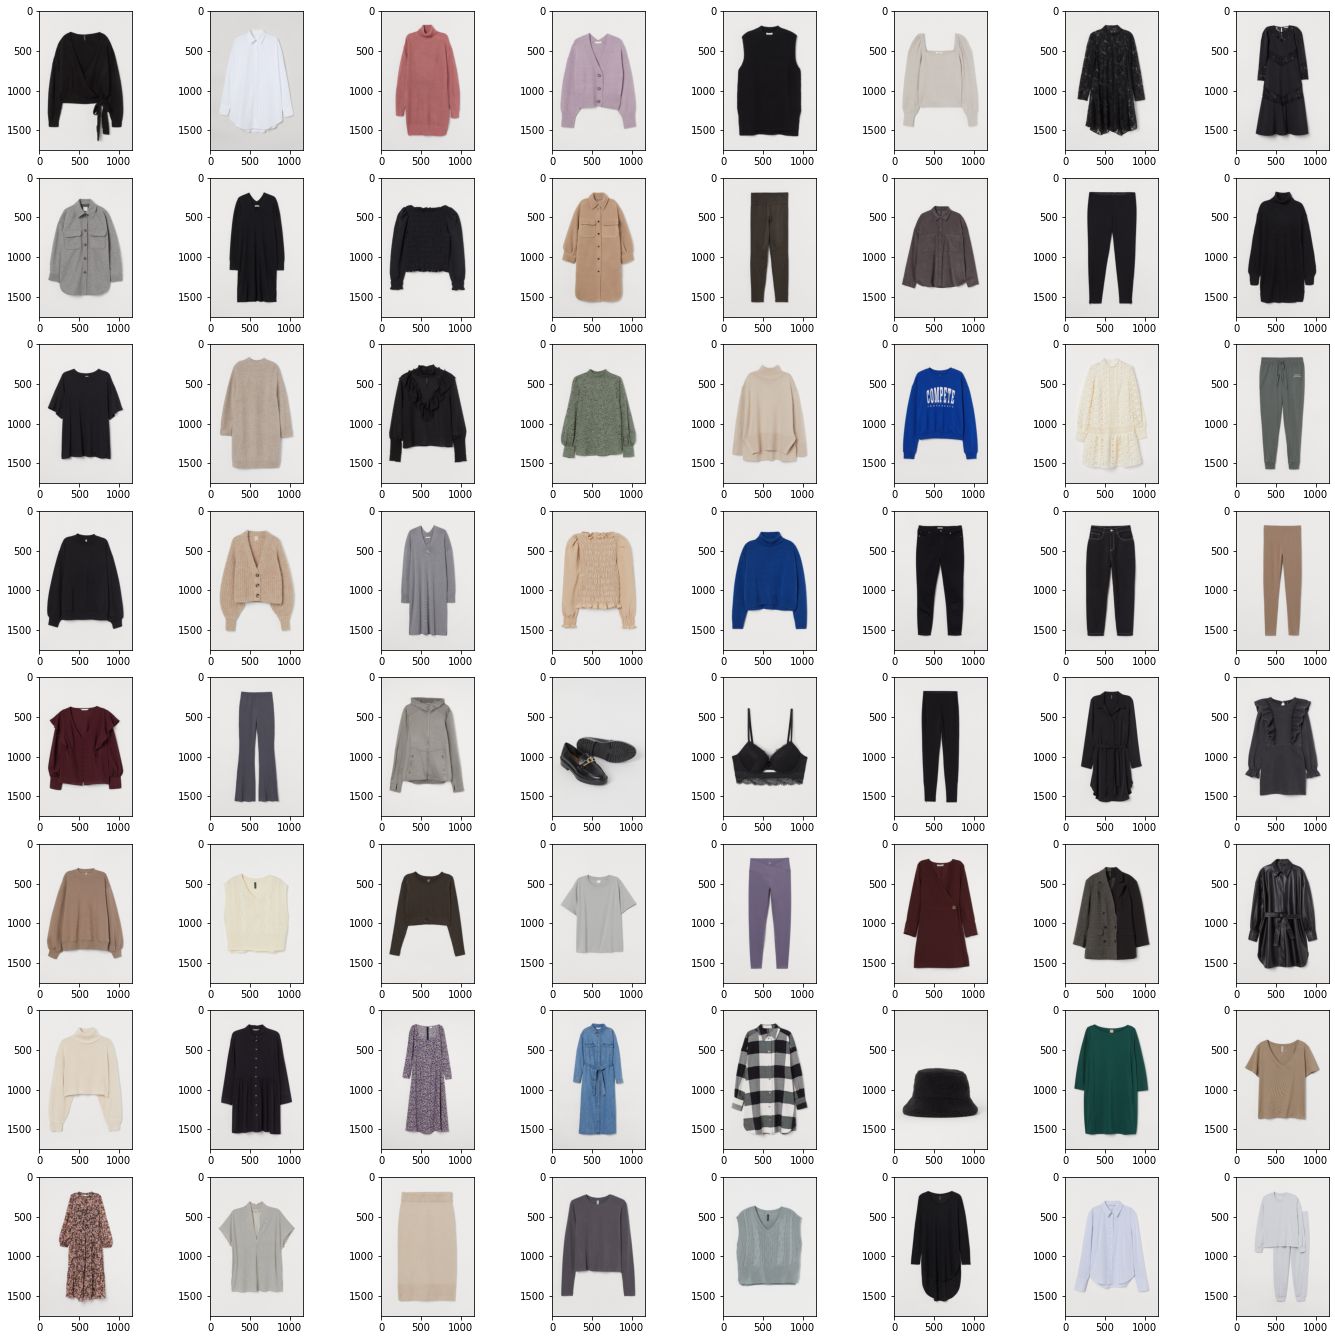

In [165]:
visualize_items(test[test['article_id'].isin(train_items_set - trending_items)]['article_id'].value_counts().index)

In [170]:
_ = (
    test[['customer_id', 'article_id', 't_dat']].drop_duplicates()
    .merge(
        train[['customer_id', 'article_id', 't_dat']].drop_duplicates(), on=['customer_id', 'article_id']
    )
)

In [145]:
test[['customer_id', 'article_id', 't_dat']].drop_duplicates().shape

(230980, 3)

In [171]:
_.shape

(5977, 4)

In [182]:
stats = (
    train
    .groupby('customer_id')
    .agg(cnt=('article_id', 'count'), first_t=('t_dat', 'min'), last_t=('t_dat', 'max'))
    .reset_index()
)

In [184]:
ext_ = _.merge(stats, on='customer_id')

In [186]:
ext_['cnt'].describe()

count   5977.0000
mean      14.2848
std       17.5488
min        1.0000
25%        4.0000
50%        9.0000
75%       17.0000
max      199.0000
Name: cnt, dtype: float64

<AxesSubplot:>

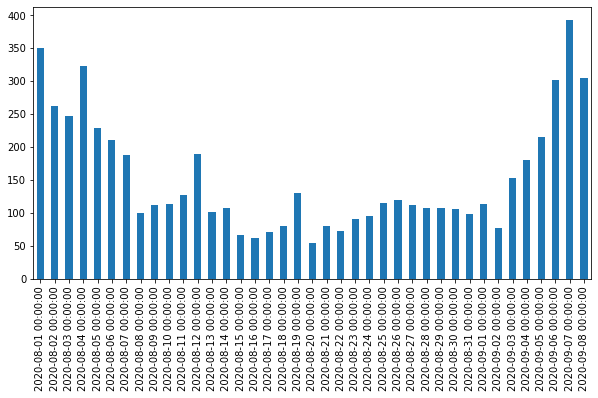

In [190]:
ext_['first_t'].value_counts().sort_index().plot.bar()

In [177]:
# customers that are bought something from train period in test period
_['customer_id'].nunique() / test['customer_id'].nunique() * 100

5.937322095558117

In [178]:
# transactions that are repeated
(5977 / 230980) * 100

2.5876699281323057

In [144]:
_.sample(n=15)

,customer_id,article_id,t_dat_x,t_dat_y
5776,791a4b1cee8b541b59a778bf4c921a1d11ceb097aa91a6...,0904424002,2020-09-15,2020-09-03
1218,bfc1c2dc1b9baf9c19ac3c6dcaff491e85c358057c12b2...,0884319005,2020-09-09,2020-09-07
266,258ec2f157c68e14fb74c983bd610ce3c63f1843d40ed9...,0903084002,2020-09-09,2020-08-27
1922,4079ff910983750e8f5f008a06d5d5307c0c31ae49500e...,0878200010,2020-09-10,2020-08-30
353,34422f585cbdaa0fecfa84abb75e9c3a07b366c4be7f41...,0880839001,2020-09-09,2020-09-05
2145,736641738086589101190b055c9179c7357262e8d48d9d...,0730683019,2020-09-10,2020-08-15
4371,078c3a589ddd69624561a14e77de0429631bc2c4dc2cd8...,0372860001,2020-09-13,2020-08-28
1433,e4c241fd875400c322fd330b1891ade9ef0774dbde9733...,0933989001,2020-09-09,2020-09-07
3450,9de4cb3987eb0881c01a553a42e3cfffc4cc65230b7a3a...,0685814022,2020-09-11,2020-08-27
3523,b1748ccdf6e94121ba4627962edd5544821e2f99d662c9...,0829438001,2020-09-11,2020-08-30


In [143]:
(_['t_dat_x'] - _['t_dat_y']).describe()

count                          5977
mean     10 days 19:41:58.253304333
std       9 days 19:35:58.697209649
min                 1 days 00:00:00
25%                 4 days 00:00:00
50%                 7 days 00:00:00
75%                15 days 00:00:00
max                45 days 00:00:00
dtype: object

In [194]:
_['article_id'].value_counts()[:20]

0751471043    34
0448509014    30
0751471001    30
0706016001    25
0933706001    22
0898694001    20
0910601002    19
0915526001    19
0863583001    19
0762846027    19
0891591007    18
0863583002    18
0762846026    18
0916468003    17
0762846031    17
0896152002    16
0891591003    16
0866731001    16
0918292001    16
0877769001    16
Name: article_id, dtype: int64

/data/sstamenov/kaggle-data//images/086/0863646002.jpg not found


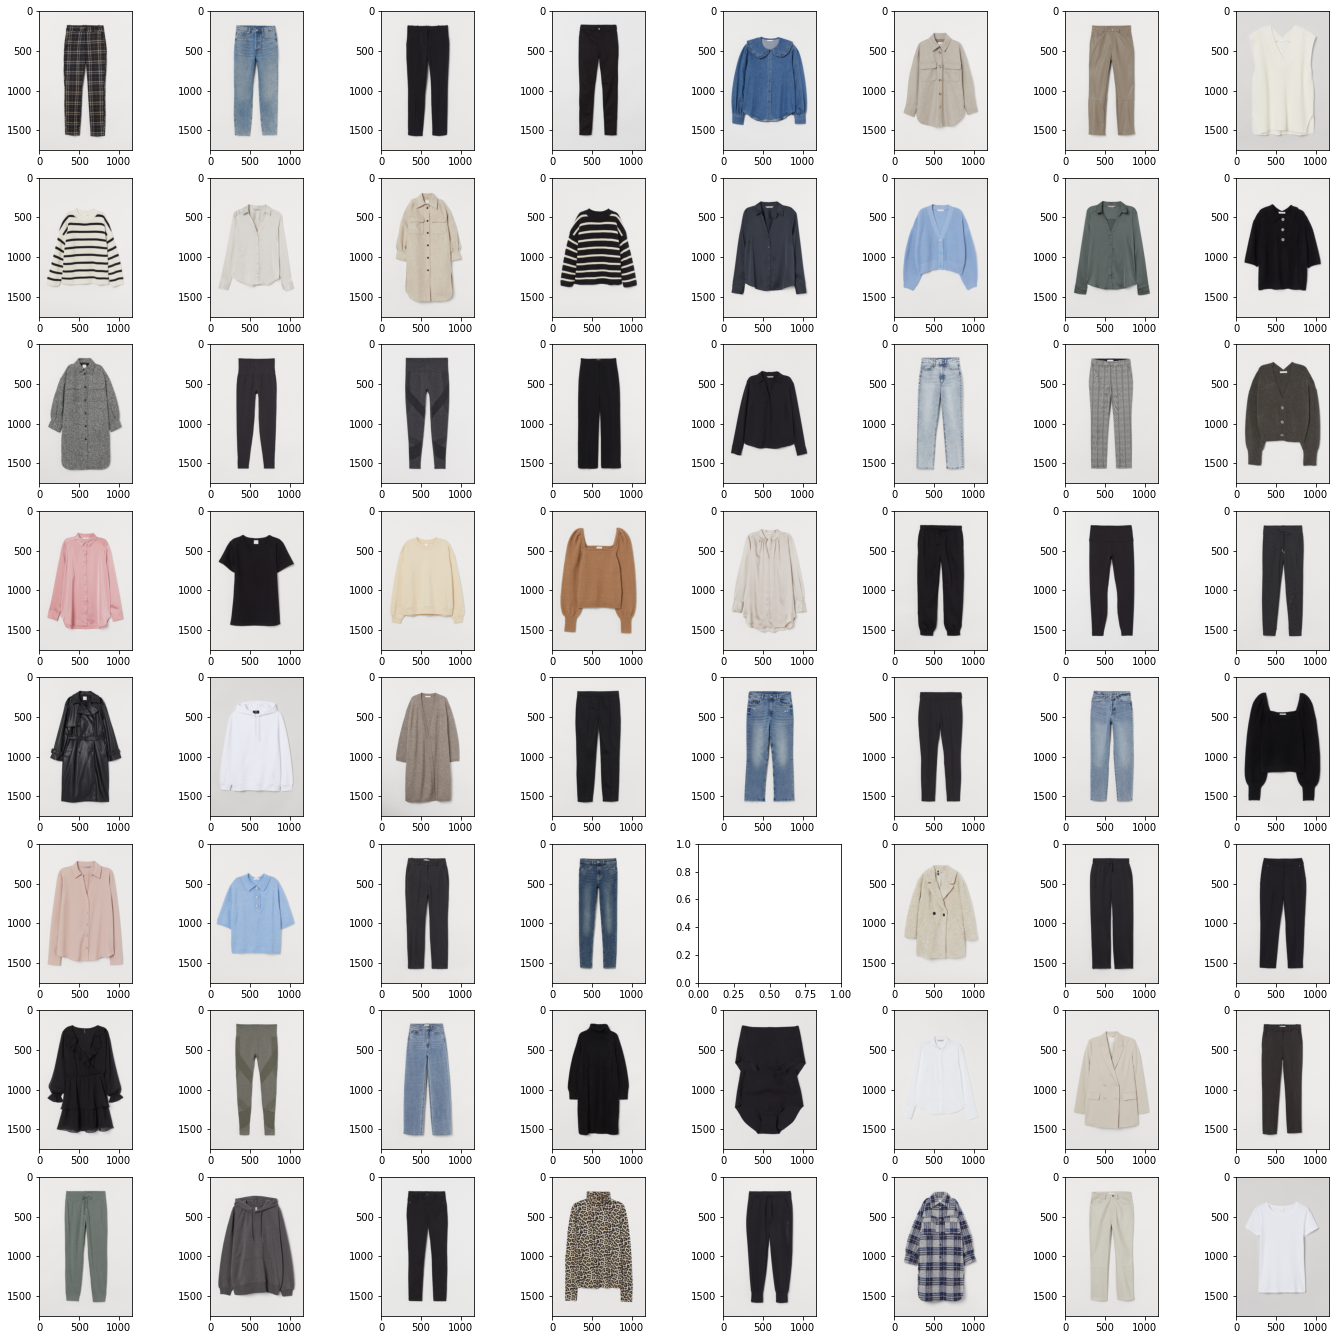

In [191]:
visualize_items(_['article_id'].value_counts().index)

# customer activity
how many customers that we'rent active in last 6w will buy in test period?

In [209]:
last_weeks

<PeriodArray>
['2020-07-27/2020-08-02', '2020-08-03/2020-08-09', '2020-08-10/2020-08-16',
 '2020-08-17/2020-08-23', '2020-08-24/2020-08-30', '2020-08-31/2020-09-06']
Length: 6, dtype: period[W-SUN]

In [203]:
most_recent_customers = set(train[train['week_no'].isin(last_weeks)]['customer_id'].unique())

In [215]:
train[train['week_no'].isin(last_weeks)].groupby('customer_id', observed=True).agg(cnt=('article_id', 'count'))['cnt'].describe()

count   289593.0000
mean         5.0608
std          5.5793
min          1.0000
25%          2.0000
50%          3.0000
75%          6.0000
max        228.0000
Name: cnt, dtype: float64

In [216]:
train[train['week_no'].isin(last_weeks)].groupby('article_id', observed=True).agg(cnt=('customer_id', 'count'))['cnt'].describe()

count   31693.0000
mean       46.2431
std       118.1665
min         1.0000
25%         2.0000
50%         8.0000
75%        35.0000
max      2748.0000
Name: cnt, dtype: float64

In [206]:
len(set(train['customer_id']))

300094

In [204]:
len(set(train['customer_id']) - most_recent_customers)

10501

In [208]:
10501 / 300094 * 100

3.4992369057695254